# API security: Access behavior anomaly dataset

**Date:** 22 November 2024

**Link to dataset:** https://www.kaggle.com/datasets/tangodelta/api-access-behaviour-anomaly-dataset/data

In [1]:
import sys
import os

sys.path.append(os.path.abspath("../../"))

In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from cybergpt.datasets.graphs import GraphDataset

In [3]:
SUPERVISED_LABELS_PATH = "../../data/kaggle/api_security/supervised_dataset.csv"
SUPERVISED_PATH = "../../data/kaggle/api_security/supervised_call_graphs.json"
REMAINING_LABELS_PATH = "../../data/kaggle/api_security/remaining_behavior_ext.csv"
REMAINING_PATH = "../data/../kaggle/api_security/remaining_call_graphs.json"

In [4]:
supervised_labels = pd.read_csv(SUPERVISED_LABELS_PATH)
supervised_data = json.load(open(SUPERVISED_PATH, "r"))
remaining_labels = pd.read_csv(REMAINING_LABELS_PATH)
remaining_data = json.load(open(REMAINING_PATH, "r"))
data = supervised_data + remaining_data

In [5]:
len(supervised_data)

1699

In [6]:
len(remaining_data)

34423

In [7]:
supervised_lengths = [
    len(c["call_graph"]) for c in supervised_data if c.get("call_graph")
]
remaining_lengths = [
    len(c["call_graph"]) for c in remaining_data if c.get("call_graph")
]

In [8]:
def plot_comparison(supervised_lengths, remaining_lengths):
    plt.figure(figsize=(6, 4))

    sns.kdeplot(
        data=supervised_lengths, label="supervised", log_scale=True, warn_singular=False
    )
    sns.kdeplot(
        data=remaining_lengths, label="remaining", log_scale=True, warn_singular=False
    )

    plt.xlabel("API Calls (log scale)")
    plt.ylabel("Density")
    plt.title("Distribution of API Calls")
    plt.legend()

    return plt.gcf()

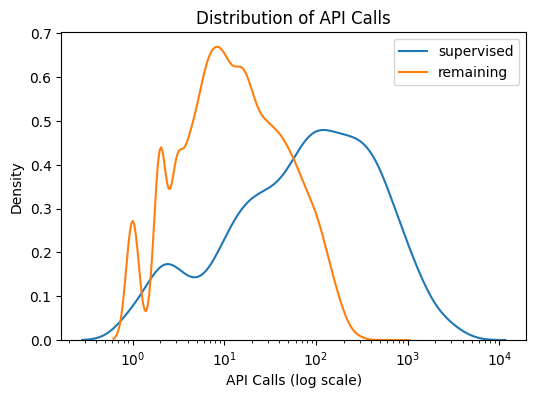

In [9]:
plot_comparison(supervised_lengths, remaining_lengths)
plt.show()

In [10]:
print(
    f"Fraction of sessions which are labelled: {len(supervised_data) / len(data):.3f}"
)
print(
    f"Fraction of transitions which are from labelled sessions: {sum(supervised_lengths) / sum(supervised_lengths + remaining_lengths):.3f}"
)

Fraction of sessions which are labelled: 0.047
Fraction of transitions which are from labelled sessions: 0.309


In [11]:
supervised_labels["classification"].value_counts(normalize=True)

classification
normal     0.650971
outlier    0.349029
Name: proportion, dtype: float64

In [12]:
labels = pd.concat([supervised_labels, remaining_labels])
n_sessions = labels["num_sessions"].sum()
avg_users = labels["num_users"].mean()
avg_sessions = labels["num_sessions"].mean()

In [13]:
print(f"Sessions: {n_sessions:.0f}")
print(f"Average users per graph: {avg_users:.2f}")
print(f"Average sessions per graph: {avg_sessions:.2f}")

Sessions: 1299571
Average users per graph: 22.55
Average sessions per graph: 35.98


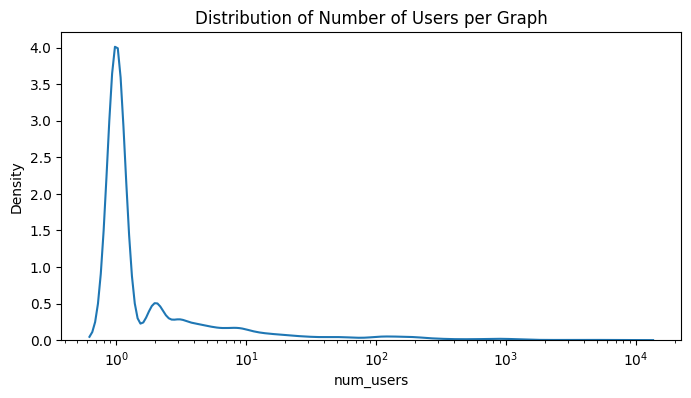

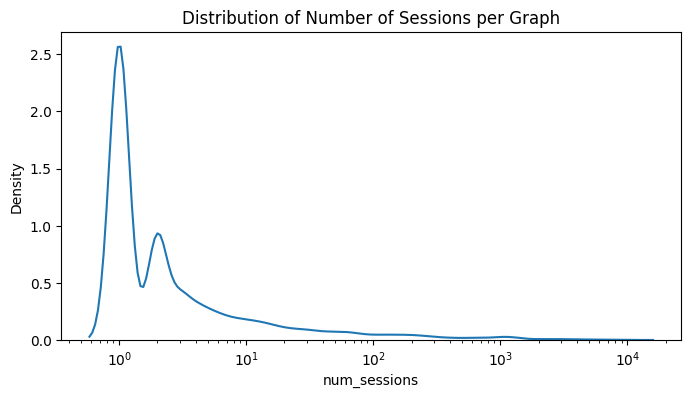

In [14]:
plt.figure(figsize=(8, 4))
sns.kdeplot(labels["num_users"], log_scale=True)
plt.title("Distribution of Number of Users per Graph")
plt.show()

plt.figure(figsize=(8, 4))
sns.kdeplot(labels["num_sessions"], log_scale=True)
plt.title("Distribution of Number of Sessions per Graph")
plt.show()

# Summary Stats

In [15]:
def to_graph_dataset(data: list[dict]) -> GraphDataset:
    edge_lists = []
    for session in data:
        if len(session["call_graph"]) > 0:
            edge_list = [
                (edge["fromId"], edge["toId"]) for edge in session["call_graph"]
            ]
            edge_lists.append(edge_list)
        else:
            edge_lists.append([])
    return GraphDataset(edge_lists)

In [16]:
dataset = to_graph_dataset(data)

In [17]:
metrics = dataset.calculate_metrics()

Calculating graph metrics: 100%|█████████| 36122/36122 [03:24<00:00, 176.52it/s]


In [18]:
scalar_metrics = {k: v for k, v in metrics.items() if k in dataset.SCALAR_METRICS}
array_metrics = {k: v for k, v in metrics.items() if k in dataset.ARRAY_METRICS}

In [19]:
dataset.get_vocab_size()

1640

In [20]:
scalar_metrics

{'ambient_size': 1640,
 'ambient_density': 0.011636333874015982,
 'ambient_avg_clustering': 0.5420735463609339,
 'ambient_avg_degree': 38.14390243902439,
 'ambient_scc': 137,
 'ambient_graph_entropy': 9.741869856471864,
 'ambient_modularity': 0.5224159801489328,
 'ambient_avg_branching': 19.5609756097561}

In [21]:
{k: np.mean(v) for k, v in array_metrics.items()}

{'sizes': 17.772659321189302,
 'densities': 0.20292406739888236,
 'scc_counts': 5.486318758815233,
 'graph_entropies': 2.284821310751039,
 'modularities': 0.34030652375271175,
 'branching_factors': 1.6404962211378682,
 'graphs_per_edge_distribution': 0.0011993798155711904}